# Machine Learning to predict tomorrow's closing price % change

## Trial on Bitcoin csv to do feature engineering and try out different models before running the model on all of other Cryptos

## Data Preprocessing

Import packages

In [36]:
import csv
import pandas as pd
import numpy as np
from stockstats import wrap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from geopy import distance
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

Read CSV and remove y

In [3]:
data = pd.read_csv('data/Bitcoin.csv', index_col='Date')

date = '2021-08-28'
data = data[:date]

y = data['Close']
data = data.drop(['Currency', 'Close'], axis=1)
df = wrap(data)

In [4]:
df.tail(20)

,open,high,low,volume
Date,,,,
2021-08-09,43794.9,46460.7,42824.1,117080
2021-08-10,46281.8,46663.4,44681.2,80549
2021-08-11,45593.2,46736.5,45367.9,75434
2021-08-12,45562.3,46213.8,43814.7,81071
2021-08-13,44404.0,47836.0,44242.4,75268
2021-08-14,47809.6,48090.9,46117.2,64292
2021-08-15,47082.6,47344.1,45564.1,58107
2021-08-16,46991.6,48002.4,45672.1,2411
2021-08-17,45907.5,47140.6,44441.3,84141


Use package: stockstats to handle all data into moving averages, so that to make sure we are not using future data to train out models.

We only use simple moving average, exponential moving average, standard deviation and variance moving average on high, low, and volume data, we also won't use open since it is highly associated with close data.

In [5]:
X = df[[
'high_2_sma', 'high_5_sma', 'high_10_sma', 'high_20_sma', 'high_50_sma', 'high_100_sma', 'high_2_ema', 'high_5_ema', 'high_10_ema', 'high_20_ema','high_50_ema', 'high_100_ema', 'high_5_mvar', 'high_20_mvar', 'high_50_mvar', 'high_100_mvar', 'high_5_mstd', 'high_20_mstd', 'high_50_mstd', 'high_100_mstd',
'low_2_sma', 'low_5_sma', 'low_10_sma', 'low_20_sma', 'low_50_sma', 'low_100_sma', 'low_2_ema', 'low_5_ema', 'low_10_ema', 'low_20_ema','low_50_ema', 'low_100_ema', 'low_5_mvar', 'low_20_mvar', 'low_50_mvar', 'low_100_mvar', 'low_5_mstd', 'low_20_mstd', 'low_50_mstd', 'low_100_mstd',
'volume_2_sma', 'volume_5_sma', 'volume_10_sma', 'volume_20_sma', 'volume_50_sma', 'volume_100_sma', 'volume_2_ema', 'volume_5_ema', 'volume_10_ema', 'volume_20_ema','volume_50_ema', 'volume_100_ema', 'volume_5_mvar', 'volume_20_mvar', 'volume_50_mvar', 'volume_100_mvar', 'volume_5_mstd', 'volume_20_mstd', 'volume_50_mstd', 'volume_100_mstd'
]]

X.tail(5)

,high_2_sma,high_5_sma,high_10_sma,high_20_sma,high_50_sma,high_100_sma,high_2_ema,high_5_ema,high_10_ema,high_20_ema,...,volume_50_ema,volume_100_ema,volume_5_mvar,volume_20_mvar,volume_50_mvar,volume_100_mvar,volume_5_mstd,volume_20_mstd,volume_50_mstd,volume_100_mstd
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-24,50173.1,49777.78,48439.32,47049.780,40371.872,39145.468,49945.222739,49508.068155,48622.281366,46734.867236,...,81073.794767,98531.248913,7.096208e+08,1.111900e+09,1.059427e+09,6.580693e+09,26638.707976,33345.171003,32548.833257,81121.470129
2021-08-25,49538.8,49755.16,48627.93,47442.975,40655.236,39172.316,49468.540913,49415.445437,48732.812027,46972.517975,...,80386.351835,97838.432102,5.596441e+08,9.441212e+08,1.061385e+09,6.352079e+09,23656.798233,30726.554773,32578.907846,79699.931500
2021-08-26,49289.0,49680.90,48762.47,47747.695,40941.460,39208.085,49388.046971,49392.896958,48844.628022,47198.735311,...,80127.592940,97362.185922,1.232652e+08,8.550506e+08,1.061179e+09,6.351655e+09,11102.487805,29241.248115,32575.742141,79697.272454
2021-08-27,49244.9,49613.24,48962.61,47969.930,41245.836,39264.339,49224.015657,49309.264639,48898.695654,47383.808138,...,79434.942236,96671.152538,3.992880e+07,7.533005e+08,1.042695e+09,3.889307e+09,6318.923773,27446.320492,32290.789223,62364.310655
2021-08-28,49215.7,49371.36,49291.06,48170.195,41550.040,39332.974,49267.605219,49302.643092,48969.732808,47565.293077,...,77760.120972,95484.139616,2.326105e+08,7.136302e+08,1.070822e+09,3.672078e+09,15251.574484,26713.858531,32723.422913,60597.671207


Convert it to percentage change from previous rows

In [6]:
z = X.pct_change()
z.tail(5)

,high_2_sma,high_5_sma,high_10_sma,high_20_sma,high_50_sma,high_100_sma,high_2_ema,high_5_ema,high_10_ema,high_20_ema,...,volume_50_ema,volume_100_ema,volume_5_mvar,volume_20_mvar,volume_50_mvar,volume_100_mvar,volume_5_mstd,volume_20_mstd,volume_50_mstd,volume_100_mstd
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-24,0.003672,0.011522,0.003639,0.010623,0.007259,0.000021,-0.003902,0.003439,0.005631,0.007060,...,-0.003419,-0.004952,-0.038813,-0.000766,-0.002703,-0.003239,-0.019599,-0.000383,-0.001352,-0.001621
2021-08-25,-0.012642,-0.000454,0.003894,0.008357,0.007019,0.000686,-0.009544,-0.001871,0.002273,0.005085,...,-0.008479,-0.007031,-0.211348,-0.150894,0.001849,-0.034740,-0.111939,-0.078531,0.000924,-0.017524
2021-08-26,-0.005043,-0.001493,0.002767,0.006423,0.007040,0.000913,-0.001627,-0.000456,0.002294,0.004816,...,-0.003219,-0.004868,-0.779744,-0.094342,-0.000194,-0.000067,-0.530685,-0.048340,-0.000097,-0.000033
2021-08-27,-0.000895,-0.001362,0.004104,0.004654,0.007434,0.001435,-0.003321,-0.001693,0.001107,0.003921,...,-0.008644,-0.007098,-0.676074,-0.118999,-0.017418,-0.387670,-0.430855,-0.061383,-0.008747,-0.217485
2021-08-28,-0.000593,-0.004875,0.006708,0.004175,0.007375,0.001748,0.000886,-0.000134,0.001453,0.003830,...,-0.021084,-0.012279,4.825633,-0.052662,0.026976,-0.055853,1.413635,-0.026687,0.013398,-0.028328


Also convert y into percentage change

In [7]:
y = pd.DataFrame(y)
y_change = y.pct_change()
y_change.tail(5)

,Close
Date,
2021-08-24,-0.036839
2021-08-25,0.026822
2021-08-26,-0.044146
2021-08-27,0.047675
2021-08-28,-0.003408


Join back the dataset

In [8]:
df = z.join(y_change, on='Date')

# Remove date column, we don't need it to train our model
df = df.reset_index()
df = df.iloc[: , 1:]

Remove the last row, which is the newest date, we are going to use it as the input for our model to get the newest day closing price % change.

In [9]:
newest_date = df.iloc[-1:].copy()
newest_date = newest_date.fillna(0)
df.drop(df.tail(1).index,inplace=True)
newest_date

,high_2_sma,high_5_sma,high_10_sma,high_20_sma,high_50_sma,high_100_sma,high_2_ema,high_5_ema,high_10_ema,high_20_ema,...,volume_100_ema,volume_5_mvar,volume_20_mvar,volume_50_mvar,volume_100_mvar,volume_5_mstd,volume_20_mstd,volume_50_mstd,volume_100_mstd,Close
4059,-0.000593,-0.004875,0.006708,0.004175,0.007375,0.001748,0.000886,-0.000134,0.001453,0.00383,...,-0.012279,4.825633,-0.052662,0.026976,-0.055853,1.413635,-0.026687,0.013398,-0.028328,-0.003408


Drop NaN and Infinity

In [10]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

Train Test Split

In [11]:
df

,high_2_sma,high_5_sma,high_10_sma,high_20_sma,high_50_sma,high_100_sma,high_2_ema,high_5_ema,high_10_ema,high_20_ema,...,volume_100_ema,volume_5_mvar,volume_20_mvar,volume_50_mvar,volume_100_mvar,volume_5_mstd,volume_20_mstd,volume_50_mstd,volume_100_mstd,Close
102,0.000000,0.111111,0.071429,0.041667,0.018182,0.009524,0.004141,0.036530,0.052498,0.047849,...,0.000654,-0.234689,-0.252165,-0.008432,-0.002566,-0.125179,-0.135226,-0.004225,-0.001284,0.000000
109,0.000000,0.000000,0.000000,0.031250,0.016129,0.008850,-0.166666,-0.046196,-0.006304,0.012783,...,0.007520,-0.010934,0.000861,-0.010237,-0.000126,-0.005482,0.000431,-0.005132,-0.000063,0.000000
110,0.000000,0.090909,0.047619,0.060606,0.031746,0.017544,0.233334,0.118233,0.083123,0.064749,...,0.014156,-0.030406,-0.068042,-0.012347,0.003513,-0.015320,-0.034620,-0.006193,0.001755,0.500000
111,0.600000,0.250000,0.136364,0.114286,0.061538,0.034483,0.549550,0.339702,0.225863,0.155193,...,0.009839,-0.069740,-0.018369,-0.008166,0.002390,-0.035500,-0.009227,-0.004092,0.001194,0.333333
112,0.250000,0.200000,0.120000,0.102564,0.057971,0.033333,0.118217,0.169044,0.150748,0.121549,...,0.052417,0.101643,0.434180,0.035657,0.051025,0.049592,0.197572,0.017672,0.025195,-0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4054,0.007860,0.018604,0.005548,0.011661,0.007309,-0.000036,0.014484,0.011900,0.009974,0.009368,...,-0.004802,-0.192425,-0.201567,-0.007712,0.002486,-0.101348,-0.106449,-0.003863,0.001242,0.005790
4055,0.003672,0.011522,0.003639,0.010623,0.007259,0.000021,-0.003902,0.003439,0.005631,0.007060,...,-0.004952,-0.038813,-0.000766,-0.002703,-0.003239,-0.019599,-0.000383,-0.001352,-0.001621,-0.036839
4056,-0.012642,-0.000454,0.003894,0.008357,0.007019,0.000686,-0.009544,-0.001871,0.002273,0.005085,...,-0.007031,-0.211348,-0.150894,0.001849,-0.034740,-0.111939,-0.078531,0.000924,-0.017524,0.026822
4057,-0.005043,-0.001493,0.002767,0.006423,0.007040,0.000913,-0.001627,-0.000456,0.002294,0.004816,...,-0.004868,-0.779744,-0.094342,-0.000194,-0.000067,-0.530685,-0.048340,-0.000097,-0.000033,-0.044146


In [12]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=35)

train_set = train_set.dropna()
test_set = test_set.dropna()

X_train = np.asarray(train_set.drop('Close', axis=1))
y_train = np.asarray(train_set['Close'].copy())
y_train = y_train.reshape(-1,1).ravel()

X_test = np.asarray(test_set.drop('Close', axis=1))
y_test = np.asarray(test_set['Close'].copy())
y_test = y_test.reshape(-1,1).ravel()

# Standard Scaler on X data
scalerX_train = StandardScaler().fit(X_train)
X_train = scalerX_train.transform(X_train)
X_test = scalerX_train.transform(X_test)

## Experiment different regression models to find the good ones

**First**: define two functions to evaluate our models, the fit_and_stat function fits the model and calculate the statistical scores for regressions: R2, MAE, and RMSE. 

However, while we care about these scores, we are more concern about how we actually perform in sucessfully predicting tomorrow's change on price, more importantly, whether our prediction matches the trend of the positive or negative movement of the price, and also how much we can make if we invest the same amount each date?

In [13]:
def fit_and_stat(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))


#sign_pred: positive or negative sign of prediction
#sign_true: positive or negative sign of true outcome
#is_correct: 1 if sign_pred == sign_true, else 0
#is_incorrect: opposite
#is_predicted: 1 if the model has made a valid prediction, 0 if not. This is important if models only emit predictions when they have a certain level of confidence
#result: the profit (loss) resulting from betting one unit in the direction of the sign_pred. This is the continuous variable result of following the model
#residual: the absolute value of prediction compare to the true value
def eval_score(y_pred,y_test):
    y_test = pd.Series(y_test.ravel())
    y_pred = pd.Series(y_pred)
    
    y_pred.name = 'y_pred'
    y_test.name = 'y_test'
    
    df = pd.concat([y_pred,y_test],axis=1)

    df['sign_pred'] = df.y_pred.apply(np.sign)
    df['sign_true'] = df.y_test.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
    df['is_incorrect'] = 0
    df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
    df['is_predicted'] = df.is_correct + df.is_incorrect
    df['result'] = df.sign_pred * df.y_test
    df['residual'] = np.abs(y_test - y_pred)
    return df

Then, we can test how each model performs:

1.Random Forest

In [14]:
rf = RandomForestRegressor(n_estimators=1000, random_state=35, n_jobs=-1)
fit_and_stat(rf)
y_pred_rf = rf.predict(X_test)
rf_eval = eval_score(y_pred_rf,y_test)
print(rf_eval.tail(5))
rf_correct = rf_eval.is_correct.sum()
rf_residual = rf_eval.residual.sum()

R^2 :  0.5828142686291728
MAE : 0.018974614143417567
RMSE: 0.03638840255831566
       y_pred    y_test  sign_pred  sign_true  is_correct  is_incorrect  \
765  0.028956  0.023579        1.0        1.0           1             0   
766 -0.002455  0.000314       -1.0        1.0           0             1   
767 -0.004432 -0.010944       -1.0       -1.0           1             0   
768  0.003730  0.125000        1.0        1.0           1             0   
769  0.000756 -0.027928        1.0       -1.0           0             1   

     is_predicted    result  residual  
765             1  0.023579  0.005377  
766             1 -0.000314  0.002769  
767             1  0.010944  0.006512  
768             1  0.125000  0.121270  
769             1 -0.027928  0.028684  


In [15]:
# Predict tomorrow's result
rf_result = rf.predict(newest_date.iloc[:, :-1])
print(rf_result)

[-0.0055541]


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


2.LASSO (we don't use OLS here since we want it to select features itself)

In [16]:
lasso = linear_model.LassoCV(max_iter=10000)
fit_and_stat(lasso)
y_pred_lasso = lasso.predict(X_test)
lasso_eval = eval_score(y_pred_lasso,y_test)
print(lasso_eval.tail(5))
lasso_correct = lasso_eval.is_correct.sum()
lasso_residual = lasso_eval.residual.sum()

R^2 :  0.2719394084046646
MAE : 0.023808636858759624
RMSE: 0.0480708752474493
       y_pred    y_test  sign_pred  sign_true  is_correct  is_incorrect  \
765  0.010711  0.023579        1.0        1.0           1             0   
766 -0.001346  0.000314       -1.0        1.0           0             1   
767  0.003780 -0.010944        1.0       -1.0           0             1   
768 -0.019455  0.125000       -1.0        1.0           0             1   
769 -0.005908 -0.027928       -1.0       -1.0           1             0   

     is_predicted    result  residual  
765             1  0.023579  0.012867  
766             1 -0.000314  0.001660  
767             1 -0.010944  0.014723  
768             1 -0.125000  0.144455  
769             1  0.027928  0.022020  


In [17]:
# Predict tomorrow's result
lasso_result = lasso.predict(newest_date.iloc[:, :-1])
print(lasso_result)

[0.00695237]


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


3.Support Vector Regressor

In [18]:
svcd = SVR(C=1.0, epsilon=0.001)
fit_and_stat(svcd)
y_pred_svcd = svcd.predict(X_test)
svcd_eval = eval_score(y_pred_svcd,y_test)
print(svcd_eval.tail(5))
svcd_correct = svcd_eval.is_correct.sum()
svcd_residual = svcd_eval.residual.sum()

R^2 :  0.2989624979263523
MAE : 0.023951996313791458
RMSE: 0.04717032766867225
       y_pred    y_test  sign_pred  sign_true  is_correct  is_incorrect  \
765  0.033151  0.023579        1.0        1.0           1             0   
766 -0.000699  0.000314       -1.0        1.0           0             1   
767 -0.001446 -0.010944       -1.0       -1.0           1             0   
768 -0.056305  0.125000       -1.0        1.0           0             1   
769  0.013721 -0.027928        1.0       -1.0           0             1   

     is_predicted    result  residual  
765             1  0.023579  0.009572  
766             1 -0.000314  0.001013  
767             1  0.010944  0.009498  
768             1 -0.125000  0.181305  
769             1 -0.027928  0.041649  


In [19]:
# Predict tomorrow's result
svcd_result = svcd.predict(newest_date.iloc[:, :-1])
print(svcd_result)

[0.00620801]


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


4.Stochastic Gradient Descent Regressor

In [20]:
sgdr = SGDRegressor(max_iter=10000)
fit_and_stat(sgdr)
y_pred_sgdr = sgdr.predict(X_test)
sgdr_eval = eval_score(y_pred_sgdr,y_test)
print(sgdr_eval.tail(5))
sgdr_correct = sgdr_eval.is_correct.sum()
sgdr_residual = sgdr_eval.residual.sum()

R^2 :  -1.2741984401705936e+16
MAE : 334958.43199273373
RMSE: 6359409.656892669
            y_pred    y_test  sign_pred  sign_true  is_correct  is_incorrect  \
765  111817.860112  0.023579        1.0        1.0           1             0   
766   68302.193757  0.000314        1.0        1.0           1             0   
767   95687.868084 -0.010944        1.0       -1.0           0             1   
768  -59510.053403  0.125000       -1.0        1.0           0             1   
769  250744.234360 -0.027928        1.0       -1.0           0             1   

     is_predicted    result       residual  
765             1  0.023579  111817.836534  
766             1  0.000314   68302.193443  
767             1 -0.010944   95687.879028  
768             1 -0.125000   59510.178403  
769             1 -0.027928  250744.262288  


In [21]:
# Predict tomorrow's result
sgdr_result = sgdr.predict(newest_date.iloc[:, :-1])
print(sgdr_result)

[-2276270.99362984]


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(


5.Gradient Boosting Regressor

In [22]:
gbr = GradientBoostingRegressor(random_state=35)
fit_and_stat(gbr)
y_pred_gbr = gbr.predict(X_test)
gbr_eval = eval_score(y_pred_gbr,y_test)
print(gbr_eval.tail(5))
gbr_correct = gbr_eval.is_correct.sum()
gbr_residual = gbr_eval.residual.sum()

R^2 :  0.5000164403716876
MAE : 0.020798764253830253
RMSE: 0.039836037228169155
       y_pred    y_test  sign_pred  sign_true  is_correct  is_incorrect  \
765  0.032169  0.023579        1.0        1.0           1             0   
766 -0.002708  0.000314       -1.0        1.0           0             1   
767  0.000702 -0.010944        1.0       -1.0           0             1   
768  0.023484  0.125000        1.0        1.0           1             0   
769 -0.012783 -0.027928       -1.0       -1.0           1             0   

     is_predicted    result  residual  
765             1  0.023579  0.008590  
766             1 -0.000314  0.003022  
767             1 -0.010944  0.011646  
768             1  0.125000  0.101516  
769             1  0.027928  0.015145  


In [23]:
# Predict tomorrow's result
gbr_result = gbr.predict(newest_date.iloc[:, :-1])
print(gbr_result)

[-0.0598608]


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


6.XGBoosting Regressor

In [24]:
xgb = XGBRegressor(n_estimators=1000, max_depth=50, eta=0.1, subsample=0.7, colsample_bytree=0.8)
fit_and_stat(xgb)
y_pred_xgb = xgb.predict(X_test)
xgb_eval = eval_score(y_pred_xgb,y_test)
print(xgb_eval.tail(5))
xgb_correct = xgb_eval.is_correct.sum()
xgb_residual = xgb_eval.residual.sum()

R^2 :  0.3933916465015477
MAE : 0.020553755165297904
RMSE: 0.04387856952288098
       y_pred    y_test  sign_pred  sign_true  is_correct  is_incorrect  \
765  0.032521  0.023579        1.0        1.0           1             0   
766 -0.003366  0.000314       -1.0        1.0           0             1   
767 -0.003699 -0.010944       -1.0       -1.0           1             0   
768  0.000139  0.125000        1.0        1.0           1             0   
769  0.014060 -0.027928        1.0       -1.0           0             1   

     is_predicted    result  residual  
765             1  0.023579  0.008942  
766             1 -0.000314  0.003680  
767             1  0.010944  0.007245  
768             1  0.125000  0.124861  
769             1 -0.027928  0.041988  


In [25]:
# Predict tomorrow's result
xgb_result = xgb.predict(newest_date.iloc[:, :-1])
print(xgb_result)

[-0.03255333]


In [26]:
total = len(xgb_eval.sign_pred)
total

770

Compare models

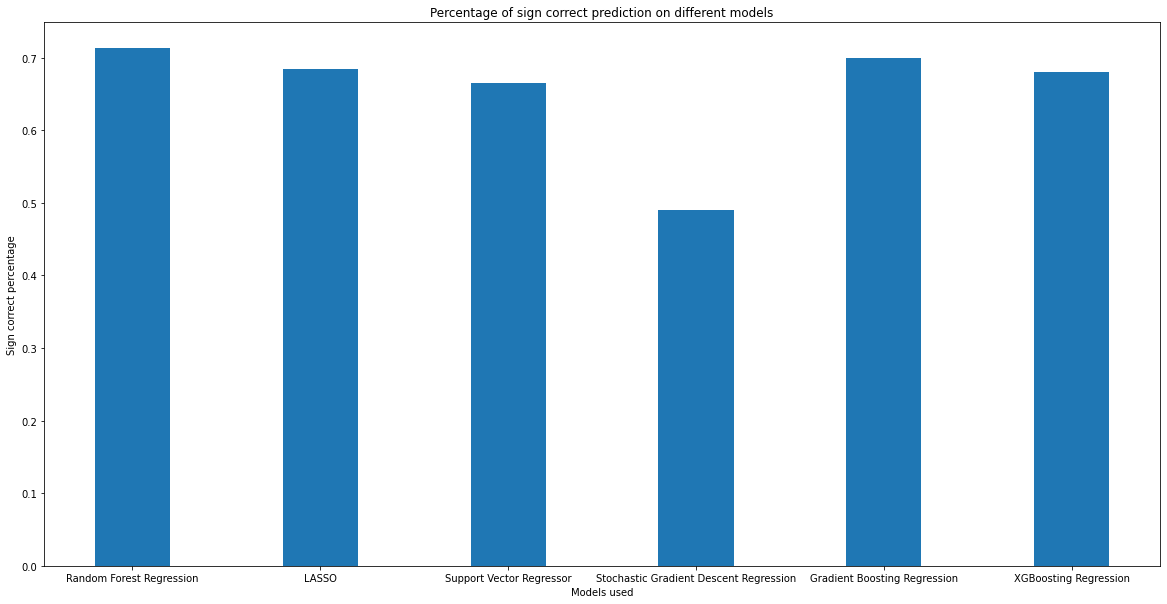

In [27]:
correct = {'Random Forest Regression':rf_correct / total,
            'LASSO':lasso_correct / total,
            'Support Vector Regressor':svcd_correct / total,
            'Stochastic Gradient Descent Regression':sgdr_correct / total,
            'Gradient Boosting Regression':gbr_correct / total,
            'XGBoosting Regression':xgb_correct / total}

models = list(correct.keys())
values = list(correct.values())

fig = plt.figure(figsize = (20, 10))
plt.bar(models, values, width = 0.4)

plt.xlabel("Models used")
plt.ylabel("Sign correct percentage")
plt.title("Percentage of sign correct prediction on different models")
plt.show()

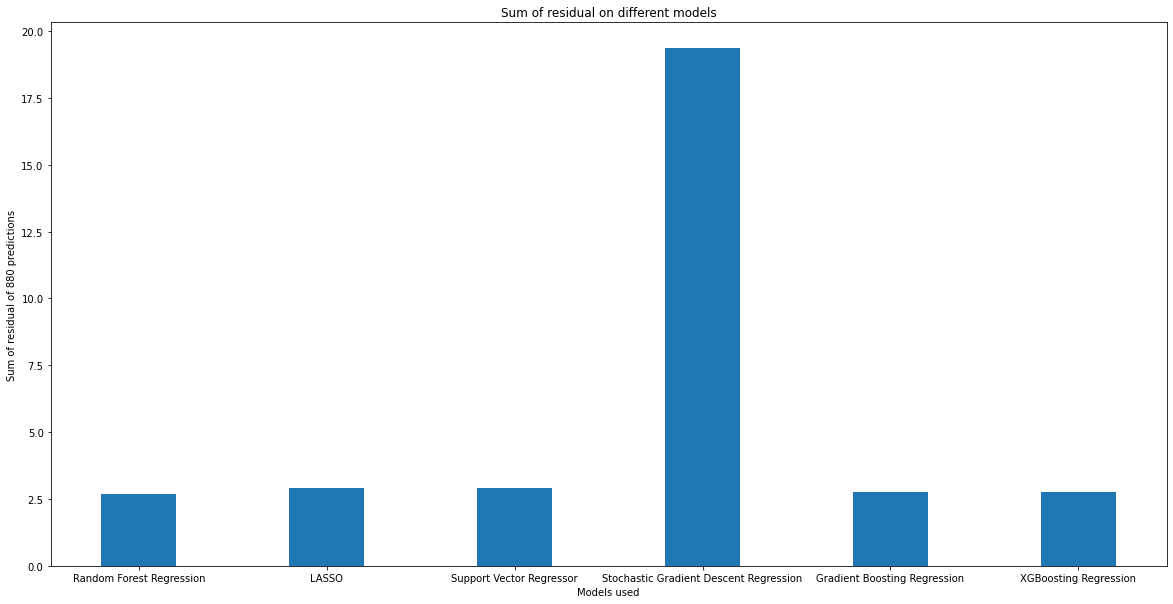

In [28]:
residual = {'Random Forest Regression':np.log(rf_residual),
            'LASSO':np.log(lasso_residual),
            'Support Vector Regressor':np.log(svcd_residual),
            'Stochastic Gradient Descent Regression':np.log(sgdr_residual),
            'Gradient Boosting Regression':np.log(gbr_residual),
            'XGBoosting Regression':np.log(xgb_residual)}

models = list(residual.keys())
values = list(residual.values())

fig = plt.figure(figsize = (20, 10))
plt.bar(models, values, width = 0.4)

plt.xlabel("Models used")
plt.ylabel("Sum of residual of 880 predictions")
plt.title("Sum of residual on different models")
plt.show()

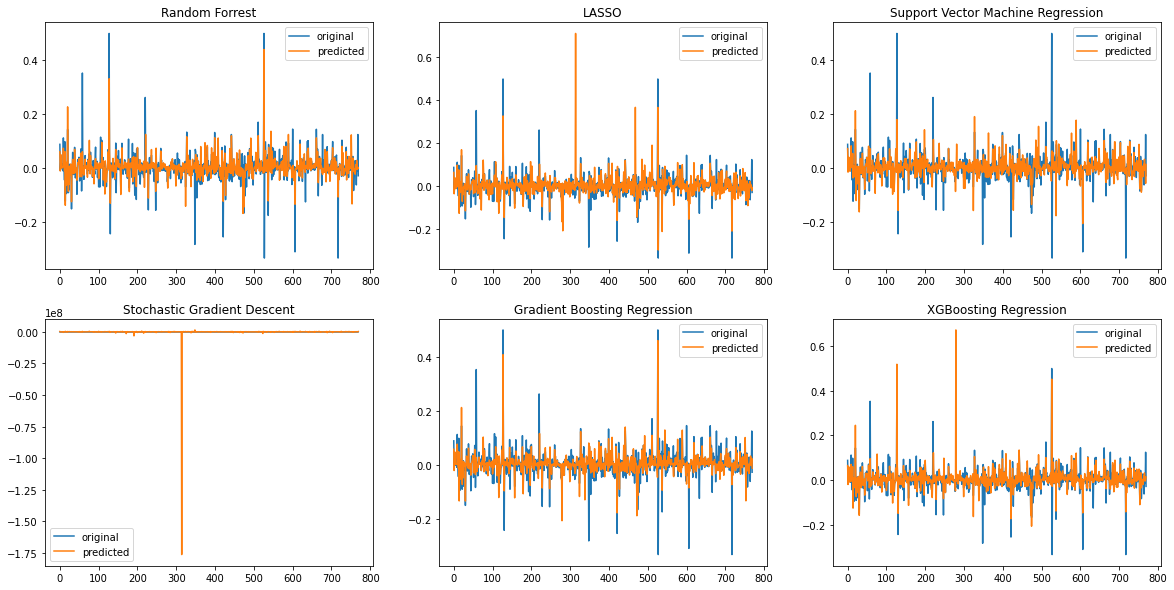

In [29]:
fig = plt.figure(figsize=(20, 10))

rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_rf, label="predicted")
plt.title("Random Forrest")
plt.legend()

fig.add_subplot(rows, columns, 2)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_lasso, label="predicted")
plt.title("LASSO")
plt.legend()

fig.add_subplot(rows, columns, 3)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_svcd, label="predicted")
plt.title("Support Vector Machine Regression")
plt.legend()

fig.add_subplot(rows, columns, 4)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_sgdr, label="predicted")
plt.title("Stochastic Gradient Descent")
plt.legend()

fig.add_subplot(rows, columns, 5)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_gbr, label="predicted")
plt.title("Gradient Boosting Regression")
plt.legend()

fig.add_subplot(rows, columns, 6)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_xgb, label="predicted")
plt.title("XGBoosting Regression")
plt.legend()

plt.show()

From these graphs, firstly we eliminate Stochastic Gradient Descent. We can also see that Random Forrest, Gradient Boosting, and XGboosting are pretty good models. Since Random Forrest are prone to having more bias, due to it is a bagging model, and both boosting models are prone to overfitting models, we can hardly decide which one to use here. Therefore, we will run all three of them and select the ones that have the best evaluation score as our prediction while running the models on all of the cryptos.

## Machine Learning using selected models

In [30]:
# get files
def files(dir):
    names = []
    for root, dirs, files in os.walk(dir):  
        for file in files:  
            if os.path.splitext(file)[1] == '.csv':  # csv files
                names.append(file)
    return names

In [31]:
names = files(os.getcwd() + "/data")

print(names)
print(len(names))

['Celsius.csv', 'IOTA.csv', 'Axie Infinity.csv', 'chainlink.csv', 'PAX Gold.csv', 'Hedera.csv', 'bitcoin cash.csv', 'Kava.csv', 'Elrond.csv', 'Helium.csv', 'Internet Computer.csv', 'STEPN.csv', 'xrp.csv', 'Theta Network.csv', 'Bitcoin Gold.csv', 'Gnosis.csv', 'near protocol.csv', 'Synthetix.csv', 'monero.csv', 'eCash.csv', 'Flow.csv', 'KuCoin Token.csv', 'Celo.csv', 'Zilliqa.csv', 'Convex Finance.csv', 'solana.csv', 'Holo.csv', 'BitTorrent (New).csv', 'Waves.csv', 'uniswap.csv', 'Neutrino USD.csv', 'Quant.csv', 'polkadot.csv', 'ethereum classic.csv', 'Loopring.csv', 'Aave.csv', 'Zcash.csv', 'The Sandbox.csv', 'Basic Attention Token.csv', 'dogecoin.csv', 'Klaytn.csv', 'Binance USD.csv', 'Kusama.csv', 'Shiba Inu.csv', 'Neo.csv', 'unus sed leo.csv', 'cosmos.csv', 'NEM.csv', 'Lido DAO.csv', 'Decentraland.csv', 'Cronos.csv', 'stellar.csv', 'Algorand.csv', 'Arweave.csv', 'EOS.csv', 'PancakeSwap.csv', 'Mina.csv', 'Curve DAO Token.csv', 'Bitcoin SV.csv', 'tether.csv', 'Decred.csv', 'Pax Dollar

In [32]:
tmr_list = []

for file in names:
    print('Now running', file)
    data = pd.read_csv('data/'+ file, index_col='Date')

    # Slice the dataframe up to 2021.08.28
    date = '2021-08-28'
    data = data[:date]

    y = data['Close']
    data = data.drop(['Currency', 'Close'], axis=1)
    df = wrap(data)

    # 60 metrics
    X = df[[
'high_2_sma', 'high_5_sma', 'high_10_sma', 'high_20_sma', 'high_50_sma', 'high_100_sma', 'high_2_ema', 'high_5_ema', 'high_10_ema', 'high_20_ema','high_50_ema', 'high_100_ema', 'high_5_mvar', 'high_20_mvar', 'high_50_mvar', 'high_100_mvar', 'high_5_mstd', 'high_20_mstd', 'high_50_mstd', 'high_100_mstd',
'low_2_sma', 'low_5_sma', 'low_10_sma', 'low_20_sma', 'low_50_sma', 'low_100_sma', 'low_2_ema', 'low_5_ema', 'low_10_ema', 'low_20_ema','low_50_ema', 'low_100_ema', 'low_5_mvar', 'low_20_mvar', 'low_50_mvar', 'low_100_mvar', 'low_5_mstd', 'low_20_mstd', 'low_50_mstd', 'low_100_mstd',
'volume_2_sma', 'volume_5_sma', 'volume_10_sma', 'volume_20_sma', 'volume_50_sma', 'volume_100_sma', 'volume_2_ema', 'volume_5_ema', 'volume_10_ema', 'volume_20_ema','volume_50_ema', 'volume_100_ema', 'volume_5_mvar', 'volume_20_mvar', 'volume_50_mvar', 'volume_100_mvar', 'volume_5_mstd', 'volume_20_mstd', 'volume_50_mstd', 'volume_100_mstd'
]]

    # Convert all X into percentage
    z = X.pct_change()

    # Convert y into percentage
    y = pd.DataFrame(y)
    y_change = y.pct_change()

    # Join back X and y
    df = z.join(y_change, on='Date')

    # Remove date column, we don't need it to train our model
    df = df.reset_index()
    df = df.iloc[: , 1:]


    # Remove the last row, which is the newest date from df
    newest_date = df.iloc[-1:].copy()

    # Sometimes the Moving Standard Deviation is NaN, so we fill it with 0?
    # newest_date = newest_date.fillna(0)
    df.drop(df.tail(1).index,inplace=True)

    # Remove all infinity and NaN cell from df
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna()

    # Train test split
    train_set, test_set = train_test_split(df, test_size=0.2, random_state=35)
    train_set = train_set.dropna()
    test_set = test_set.dropna()

    # Set up X and y train and test
    X_train = np.asarray(train_set.drop('Close', axis=1))
    y_train = np.asarray(train_set['Close'].copy())
    y_train = y_train.reshape(-1,1).ravel()
    X_test = np.asarray(test_set.drop('Close', axis=1))
    y_test = np.asarray(test_set['Close'].copy())
    y_test = y_test.reshape(-1,1).ravel()
    
    # Scale X using standard scaler
    scalerX_train = StandardScaler().fit(X_train)
    X_train = scalerX_train.transform(X_train)
    X_test = scalerX_train.transform(X_test)

    # Fit model
    rf = RandomForestRegressor(n_estimators=1000, random_state=35, n_jobs=-1)
    rf.fit(X_train, y_train)
    #rf_result = gbr.predict(newest_date.iloc[:, :-1])
    y_pred_rf = rf.predict(X_test)
    rf_eval = eval_score(y_pred_rf,y_test)

    gbr = GradientBoostingRegressor(random_state=35)
    gbr.fit(X_train, y_train)
    #gbr_result = gbr.predict(newest_date.iloc[:, :-1])
    y_pred_gbr = gbr.predict(X_test)
    gbr_eval = eval_score(y_pred_gbr,y_test)

    xgb = XGBRegressor(n_estimators=1000, max_depth=50, eta=0.1, subsample=0.7, colsample_bytree=0.8, n_jobs=-1)
    xgb.fit(X_train, y_train)
    #xgb_result = gbr.predict(newest_date.iloc[:, :-1])
    y_pred_xgb = xgb.predict(X_test)
    xgb_eval = eval_score(y_pred_xgb,y_test)

    residual = {'rf':rf_eval.residual.sum(),
                'gbr':gbr_eval.residual.sum(),
                'xgb':xgb_eval.residual.sum()}

    model = min(residual, key=residual.get)

    # Tomorrow's change
    if model == 'rf':
        tmr = rf.predict(newest_date.iloc[:, :-1])
    elif model == 'gbr':
        tmr = gbr.predict(newest_date.iloc[:, :-1])
    elif model == 'xgb':
        tmr = xgb.predict(newest_date.iloc[:, :-1])

    tmr_list.append(tmr)


Now running Celsius.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running IOTA.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Axie Infinity.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running chainlink.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running PAX Gold.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Hedera.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running bitcoin cash.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Kava.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Elrond.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Helium.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Internet Computer.csv
Now running STEPN.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running xrp.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Theta Network.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Bitcoin Gold.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Gnosis.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running near protocol.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Synthetix.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running monero.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running eCash.csv
Now running Flow.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running KuCoin Token.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Celo.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Zilliqa.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Convex Finance.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running solana.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Holo.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running BitTorrent (New).csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Waves.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running uniswap.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Neutrino USD.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Quant.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running polkadot.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running ethereum classic.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Loopring.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Aave.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Zcash.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running The Sandbox.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Basic Attention Token.csv
Now running dogecoin.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Klaytn.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Binance USD.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Kusama.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Shiba Inu.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Neo.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running unus sed leo.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running cosmos.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running NEM.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Lido DAO.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Decentraland.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Cronos.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running stellar.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Algorand.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Arweave.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running EOS.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running PancakeSwap.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Mina.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Curve DAO Token.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Bitcoin SV.csv
Now running tether.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Decred.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Pax Dollar.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running THORChain.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running polygon.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running ethereum.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Bitcoin BEP2.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running VeChain.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running 1inch.csv
Now running Fei USD.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running litecoin.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Qtum.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Trust Wallet Token.csv
Now running bitcoin.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running cardano.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Stacks.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Dash.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Enjin Coin.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running usd coin.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Tezos.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Huobi Token.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Nexo.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running ftx token.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running dai.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running TrueUSD.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running tron.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Fantom.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running BNB.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Chiliz.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running Filecoin.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Gala.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running Maker.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Now running OKB.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Now running avalanche.csv


/Users/xiyan/.conda/envs/pythonPKG/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Create output

In [33]:
out = pd.DataFrame(list(zip(names, tmr_list)),
                    columns=['crypto', 'price change from previous day'])

out['price change from previous day'] = out['price change from previous day'].astype('float64')
out['crypto'] = out['crypto'].str[:-4]
#out.to_csv('output.csv')
#out.sort_values(by=['price change from previous day'], ascending=False)

In [34]:
out

,crypto,price change from previous day
0,Celsius,-0.003054
1,IOTA,0.003491
2,Axie Infinity,0.021081
3,chainlink,0.003002
4,PAX Gold,0.000590
...,...,...
88,Filecoin,0.005727
89,Gala,-0.019520
90,Maker,0.002563
91,OKB,-0.000694


Create two temporary CSV file for 27 Close and 28 Open

### Notice that: if there are already "tmp_ML_27.csv" and "tmp_ML_28.csv" in the folder, you need to delete them first.

In [58]:
# Notice that: if there are already "tmp_ML_27.csv" and "tmp_ML_28.csv" in the folder, you need to delete them first.
date = "2021-08-27"

with open("tmp_ML_27.csv",'a', newline = "") as f:
    csv_write = csv.writer(f)
    csv_write.writerow(["Name", "Open", "Close"])

    for file in names:
        content = pd.read_csv("data/"+ file)
        name = file.split(".")[0]
        open_price = content[content['Date'] == date].to_numpy()[0,1]
        close_price = content[content['Date'] == date].to_numpy()[0,4]
        csv_write.writerow([name, open_price, close_price])

In [59]:
# Notice that: if there are already "tmp_ML_27.csv" and "tmp_ML_28.csv" in the folder, you need to delete them first.
date = "2021-08-28"

with open("tmp_ML_28.csv",'a', newline = "") as f:
    csv_write = csv.writer(f)
    csv_write.writerow(["Name", "Open", "Close"])

    for file in names:
        content = pd.read_csv("data/"+ file)
        name = file.split(".")[0]
        open_price = content[content['Date'] == date].to_numpy()[0,1]
        close_price = content[content['Date'] == date].to_numpy()[0,4]
        csv_write.writerow([name, open_price, close_price])

Read the temporarily generated file

In [60]:
df1 = pd.read_csv('tmp_ML_27.csv')
df3 = pd.read_csv('tmp_ML_28.csv')
df3 = df3.drop(['Close'], axis=1)
df3 = df3.rename({'Open': 'Actual 2021.8.28 Open'}, axis=1)

Output prediction file

In [62]:
result = pd.concat([df1, out, df3], axis=1)
result = result.drop(['Name', 'Open'],axis=1)
result = result.set_index('crypto')
result = result.rename({'Close': 'Actual 2021.8.27 Close', 'price change from previous day':'% change'}, axis=1)
result['Predicted 8.28 Close'] = result['Actual 2021.8.27 Close']*(1+result['% change'])
result = result.sort_values(by='crypto')
result.to_csv('output_ML.csv')